
---

# **Speech Command Recognition Using Deep Learning**

## **Introduction**
This project implements a Speech Command Recognition system using a combination of Convolutional Neural Networks (CNNs) and Gated Recurrent Units (GRUs). The system processes raw audio waveforms, converts them into mel spectrograms, and classifies them into predefined speech command categories. The project utilizes TensorFlow and Librosa libraries and is trained on the Google Speech Commands Dataset.

### **Objective**
To build a robust machine learning model capable of recognizing spoken words from audio input and classifying them into specific categories. This system can serve as the foundation for voice-controlled systems or assistive technologies.

---

## **Project Components**

### **1. Data Loading**
The Google Speech Commands Dataset is loaded using TensorFlow Datasets (`tfds`). This dataset contains thousands of labeled audio samples of spoken words. 

In [3]:
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GRU, Dense, Flatten, Dropout, TimeDistributed



# Load Google Speech Commands Dataset
dataset, dataset_info = tfds.load('speech_commands', split=['train', 'test'], with_info=True, as_supervised=True)
train_data, test_data = dataset
# Inspect dataset
print(dataset_info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/85511 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.K4IBDO_0.0.3/speech_commands-train.tfrecord*...…

Generating validation examples...:   0%|          | 0/10102 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.K4IBDO_0.0.3/speech_commands-validation.tfrecor…

Generating test examples...:   0%|          | 0/4890 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.K4IBDO_0.0.3/speech_commands-test.tfrecord*...:…

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split the

### **2. Audio Preprocessing**
The audio data is preprocessed to transform raw waveforms into mel spectrograms. These spectrograms serve as input features for the neural network.
- **Mel Spectrograms**: Represent frequency-domain information as a 2D matrix.
- **Padding and Cropping**: Ensures a consistent shape for all inputs.

In [4]:
# Function to preprocess audio into mel spectrograms
def preprocess_audio(y, sr=16000, n_mels=64, fixed_length=128):
    """
    Converts audio waveform into a fixed-size mel spectrogram.
    Args:
        y: Audio waveform.
        sr: Sampling rate.
        n_mels: Number of mel filterbanks.
        fixed_length: Fixed length for time frames in spectrogram.
    Returns:
        Mel spectrogram with shape (n_mels, fixed_length).
    """
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if mel_spectrogram.shape[1] < fixed_length:
        padding = fixed_length - mel_spectrogram.shape[1]
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, padding)), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :fixed_length]
    return mel_spectrogram
# Function to preprocess dataset examples
def preprocess_dataset(example):
    """
    Processes dataset examples into spectrograms and prepares labels.
    Args:
        example: A tuple (audio waveform, label).
    Returns:
        Tuple (mel spectrogram, label).
    """
    audio, label = example
    audio = audio.numpy().astype(np.float32)
    if audio.max() > 1.0 or audio.min() < -1.0:
        audio /= np.max(np.abs(audio))
    mel_spectrogram = preprocess_audio(audio, sr=16000)
    mel_spectrogram = np.expand_dims(mel_spectrogram, axis=-1)  # Add channel dimension
    return mel_spectrogram, label.numpy()


### **3. Dataset Preparation**
The training and testing datasets are converted into arrays of spectrograms (`X`) and labels (`y`) using the preprocessing functions. Labels are one-hot encoded to match the output layer of the neural network.

In [5]:
# Preprocess train/test data
def prepare_data(dataset, num_samples):
    X, y = [], []
    for example in dataset.take(num_samples):
        spectrogram, label = preprocess_dataset(example)
        X.append(spectrogram)
        y.append(label)
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_data, 5000)
X_test, y_test = prepare_data(test_data, 1000)

# Normalize spectrograms
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode labels
num_classes = dataset_info.features['label'].num_classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

### **4. Model Architecture**
A hybrid neural network combining CNN and GRU layers is designed to learn spatial and temporal patterns in the input data:
- **Convolutional Layers**: Extract spatial features from spectrograms.
- **GRU Layer**: Captures sequential dependencies in the data.
- **Dropout Layers**: Reduce overfitting.

In [6]:
# Build the CNN + GRU model
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        TimeDistributed(Flatten()),
        GRU(128, return_sequences=False),
        Dropout(0.25),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile the model
input_shape = X_train.shape[1:]  # Shape: (frequency_bins, time_steps, 1)
model = build_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()    

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 126, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 14, 1920)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 807,564 (3.08 MB)

 Trainable params: 807,564 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

### **5. Training**
The model is compiled using the Adam optimizer and trained for 10 epochs. Training progress is monitored using validation data.

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 220ms/step - accuracy: 0.6195 - loss: 1.6495 - val_accuracy: 0.0860 - val_loss: 2.9834
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 212ms/step - accuracy: 0.6418 - loss: 1.5054 - val_accuracy: 0.0860 - val_loss: 3.1928
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.6276 - loss: 1.5211 - val_accuracy: 0.1640 - val_loss: 2.7756
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 218ms/step - accuracy: 0.6437 - loss: 1.4482 - val_accuracy: 0.1660 - val_loss: 2.7172
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.6275 - loss: 1.4536 - val_accuracy: 0.1670 - val_loss: 2.5877
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.6447 - loss: 1.3320 - val_accuracy: 0.1500 - val_loss: 2.6075
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.6450 - loss: 1.2827 - val_accuracy: 0.2160 - val_loss: 2.3025
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.6599 - loss: 1

### **6. Evaluation**
The trained model is evaluated on the test dataset to compute accuracy and loss.

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3003 - loss: 2.0191
Test Accuracy: 0.30799999833106995


### **7. Model Saving**
The trained model is saved in the HDF5 format for reuse or deployment.

In [9]:
model.save('speech_recognition_model.h5')


### **8. Visualization**
Plots are generated to visualize training and validation performance for both accuracy and loss over the epochs.

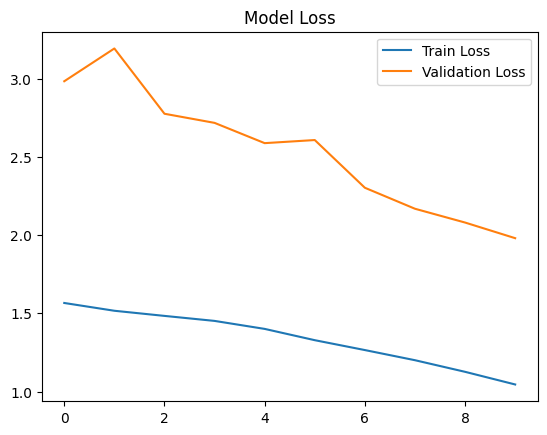

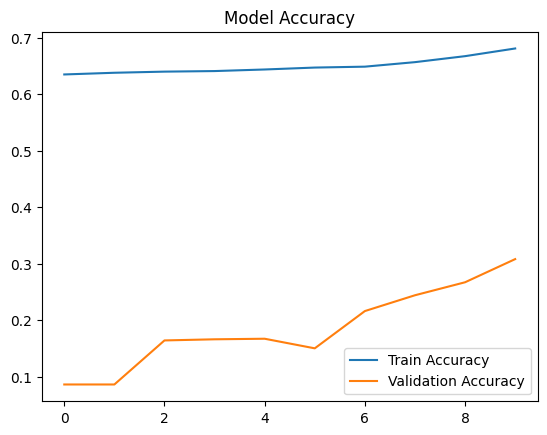

In [10]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Visualize training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

## **Key Features**

- **Automatic Preprocessing**: Converts audio waveforms to mel spectrograms.
- **Hybrid Model**: Combines CNNs for spatial feature extraction and GRUs for sequential pattern learning.
- **Visualization**: Provides clear performance metrics with accuracy and loss curves.
- **Scalability**: Can be adapted to larger datasets and different audio tasks.

---

## **Usage and Applications**

- **Voice-Activated Devices**: Power smart assistants and IoT devices.
- **Assistive Technology**: Enable voice commands for accessibility tools.
- **Speech Analytics**: Analyze and interpret spoken commands in various domains.


## **Future Enhancements**

- Extend support to multi-lingual datasets.
- Implement real-time inference for live speech recognition.
- Optimize the model for deployment on edge devices.
---